In [55]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [56]:
ind="stashcp-2016.7"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467433769609,
                  "lte": 1467437864765,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467472745553,
                  "lte": 1467474804348,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [57]:
page= es.search(index=ind, body=myquery2, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(list(df.columns.values))

371
['download_time', 'filename', 'host', 'sitename', 'status', 'timestamp', 'begin']


In [58]:
length=df.shape[0]

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df.begin, unit='s')

/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
df

,download_time,filename,host,sitename,status,begin
timestamp,,,,,,
2016-07-02 10:28:30,120080,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,NUMEP_CE,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120077,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,GLOW-OSG,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120075,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,GLOW-OSG,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120044,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,NWICG_NDCMS,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120036,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120037,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120035,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120216,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,GLOW-OSG,Success,2016-07-02 10:26:29
2016-07-02 10:28:30,120032,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,Success,2016-07-02 10:26:29


In [60]:
jobs = pd.concat([pd.Series(1, df.begin), pd.Series(-1, df.index)]).resample('1Min', how='sum').cumsum()
index=jobs.index

df2=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC'])
df2['index']=index

length2=df2.shape[0]
df2['Origin']=0
df2['Nebraska']=0
df2['UCSD']=0
df2['US-MWT2_UIUC']=0

for i in range(length2):
    for j in range(length):
        if df['begin'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
            if df['host'].iloc[j]=='root://data.ci-connect.net':
                df2['Origin'].iloc[i]+=1
            if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                df2['Nebraska'].iloc[i]+=1
            if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                df2['US-MWT2_UIUC'].iloc[i]+=1
            if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                df2['UCSD'].iloc[i]+=1



df2
df2.to_csv('plot1.csv', sep='\t')


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


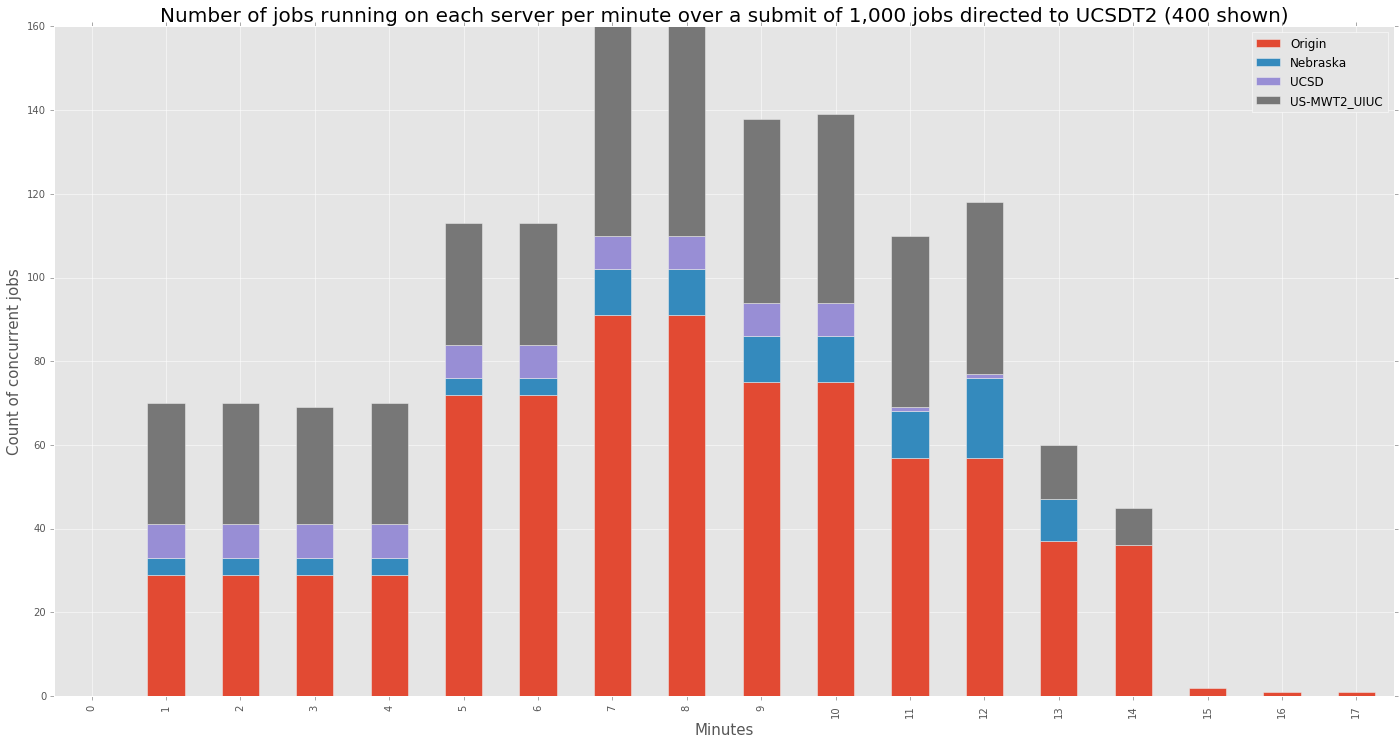

In [62]:
df2.plot.bar(stacked=True,figsize=[24, 12])
plt.title('Number of jobs running on each server per minute over a submit of 1,000 jobs directed to UCSDT2 (400 shown)', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of concurrent jobs',fontsize=15)
#plt.text(60,55,'*No GLIDEIN_ResourceName specified in condor.submit')
plt.savefig('Ilija_plot2.png')
